In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from collections import defaultdict
from scipy.linalg import svd
import seaborn as sns
import multiprocessing
from functools import partial

from causal_optoconnectics.graphics import regplot, scatterplot, probplot
from causal_optoconnectics.tools import conditional_probability, joint_probability, roll_pad
from causal_optoconnectics.tools import compute_trials_multi, decompress_events
from causal_optoconnectics.core import Connectivity
%matplotlib inline

# Process results

In [ ]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_1/')

In [3]:
x_i, x_j = 11, 13
y_i, y_j = 12, 19
z_i, z_j = 7, 10

def process_metadata(W, stim_index, params):
    
    pairs = []
    for i in range(params['n_neurons']):
        for j in range(params['n_neurons']):
            if i==j:
                continue
            pair = f'{i}_{j}'
            pairs.append({
                'source': i,
                'target': j,
                'pair': pair,
                'weight': W[i, j, 0],
                'source_stim': W[stim_index, i, 0] > 0,
                'source_stim_strength': W[stim_index, i, 0],
                'target_stim': W[stim_index, j, 0] > 0,
            })
    return pd.DataFrame(pairs)

def process(pair, trials, W, stim_index, params, n_trials=None):
    i, j = [int(a) for a in pair.split('_')]
    
    pre, post = trials[i], trials[j]
    
    n_trials = len(pre) if n_trials is None else n_trials
    
    conn = Connectivity(pre[:n_trials], post[:n_trials], x_i, x_j, y_i, y_j, z_i, z_j)
    
    result ={
        'source': i,
        'target': j,
        'pair': pair,
        'beta_iv': conn.beta_iv, 
        'beta': conn.beta,
        'beta_iv_did': conn.beta_iv_did, 
        'beta_did': conn.beta_did, 
        'hit_rate': conn.hit_rate,
        'weight': W[i, j, 0],
        'source_stim': W[stim_index, i, 0] > 0,
        'source_stim_strength': W[stim_index, i, 0],
        'target_stim': W[stim_index, j, 0] > 0,
    }
    result.update(params)
    return result

In [4]:
def multi_process(W_0, trials, params, pairs=None):
    import multiprocessing
    from functools import partial
    if pairs is None:
        pairs = []
        for i in range(params['n_neurons']):
            for j in range(params['n_neurons']):
                if i==j:
                    continue
                pairs.append(f'{i}_{j}')
    multiprocessing.freeze_support()
    with multiprocessing.Pool() as p:
        results = p.map(partial(process, W_0=W_0, trials=trials, params=params), pairs)
        
    return pd.DataFrame(results)

In [5]:
from scipy.linalg import norm
from scipy.optimize import minimize_scalar

def error(a, df, key):
    return df['weight'] - a * df[key]

def error_norm(a, df, key):
    return norm(error(a, df, key), ord=2)

def min_error(df, key):
    return minimize_scalar(error_norm, args=(df, key)).fun

In [7]:
paths = list(data_path.iterdir())
data_df = pd.DataFrame({'path': paths})
for i, fname in enumerate(paths):
    a,b,c = fname.stem.split('_')
    data_df.loc[i, 'n_neurons'], data_df.loc[i, 'stim_strength'], data_df.loc[i, 'sigma'] = a.replace('n', ''), b.replace('ss', ''), c.replace('s', '')
data_df = data_df.astype({'stim_strength': float, 'sigma': float, 'n_neurons': int})

In [8]:
data_df

,path,n_neurons,stim_strength,sigma
0,/home/users/bjornmik/datasets/sweep_1/n40_ss4_s4,40,4.0,4.0
1,/home/users/bjornmik/datasets/sweep_1/n10_ss2_s6,10,2.0,6.0
2,/home/users/bjornmik/datasets/sweep_1/n30_ss5_s5,30,5.0,5.0
3,/home/users/bjornmik/datasets/sweep_1/n10_ss1_s10,10,1.0,10.0
4,/home/users/bjornmik/datasets/sweep_1/n10_ss2_s5,10,2.0,5.0
...,...,...,...,...
272,/home/users/bjornmik/datasets/sweep_1/n50_ss5_s5,50,5.0,5.0
273,/home/users/bjornmik/datasets/sweep_1/n50_ss1_s2,50,1.0,2.0
274,/home/users/bjornmik/datasets/sweep_1/n40_ss5_s3,40,5.0,3.0
275,/home/users/bjornmik/datasets/sweep_1/n30_ss2_s9,30,2.0,9.0


In [9]:
def load(path):
    data = np.load(path / 'rank_0.npz', allow_pickle=True)   
    data = {k: data[k][()] for k in data.keys()}
    data['data'] = [np.load(fn, allow_pickle=True)['data'][()] for fn in path.glob('*.npz')]
    return data
#     data['all_params'] = [np.load(fn, allow_pickle=True)['params'][()] for fn in path.glob('*.npz')]
#     data['all_W_0'] = [np.load(fn, allow_pickle=True)['W_0'][()] for fn in path.glob('*.npz')]
#     data['all_W'] = [np.load(fn, allow_pickle=True)['W'][()] for fn in path.glob('*.npz')]
    
#     assert(all([a==b for a, b in zip(data['all_params'], data['all_params'][1:])]))
#     assert(all([np.array_equal(a,b,equal_nan=True) for a, b in zip(data['all_W_0'], data['all_W_0'][1:])]))
#     assert(all([np.array_equal(a,b,equal_nan=True) for a, b in zip(data['all_W'], data['all_W'][1:])]))
#     return data

In [13]:
values = pd.DataFrame()
for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    data = load(row.path)
    X = data['data']
    W_0 = data['W_0']
    W = data['W']
    stim_index = range(len(W))[-1]
    params = data['params']
    n_neurons = params['n_neurons']
    assert n_neurons == row.n_neurons
    trials = compute_trials_multi(X, len(W_0), stim_index)
    
    np.fill_diagonal(W_0, 0)
    s_W = svd(W_0, compute_uv=False)
    data_df.loc[i, 'W_condition'] = s_W.max() / s_W.min()
    data_df.loc[i, 'W_smin'] = s_W.min()
    data_df.loc[i, 'W_smax'] = s_W.max()

    x = decompress_events(X[0], len(W), params['n_time_step'])
    cov_x = np.cov(x[:len(W_0)])
    s_cov = svd(cov_x, compute_uv=False)
    data_df.loc[i, 'cov_condition'] = s_cov.max() / s_cov.min()
    data_df.loc[i, 'cov_smin'] = s_cov.min()
    data_df.loc[i, 'cov_smax'] = s_cov.max()

    results_meta = process_metadata(W=W, stim_index=stim_index, params=params)
    sample_meta = results_meta.query('source_stim and not target_stim and weight >= 0')
    sample = pd.DataFrame([process(pair=pair, W=W, stim_index=stim_index, trials=trials, params=params) for pair in sample_meta.pair.values])
    sample = pd.DataFrame(sample)
    sample.to_csv(data_path / 'sample.csv')
    values = pd.concat((values, sample))
    data_df.loc[i, 'error_beta'] = min_error(sample, 'beta_did')
    data_df.loc[i, 'error_beta_iv'] = min_error(sample, 'beta_iv_did')

  0%|          | 0/277 [00:00<?, ?it/s]

In [32]:
data_df.sigma = data_df.apply(lambda x: 0.5 if x.path.stem.endswith('05') else x.sigma, 1)

In [ ]:
data_df.loc[:,'error_diff'] = data_df.error_beta - data_df.error_beta_iv

In [33]:
data_df.to_csv(data_path / 'summary.csv')

In [15]:
values.to_csv(data_path / 'values.csv')

In [74]:
sub_df = data_df.query('n_neurons == 50')

/tmp/ipykernel_2421035/796403364.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())


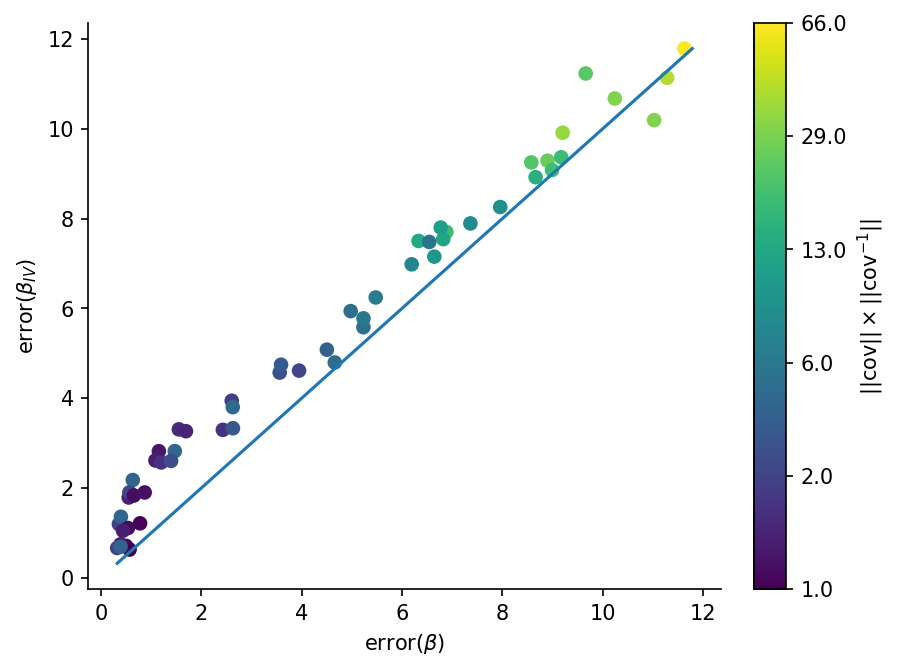

In [75]:
import matplotlib
fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(6,5), dpi=150)
mnorm = matplotlib.colors.LogNorm()
xmin, xmax = min(sub_df.error_beta.min(), sub_df.error_beta_iv.min()), max(sub_df.error_beta.max(), sub_df.error_beta_iv.max())
sc = ax.scatter(sub_df.error_beta, sub_df.error_beta_iv, c=mnorm(sub_df.cov_condition))
ax.plot([xmin, xmax], [xmin, xmax])
ax.set_xlabel(r'$\mathrm{error}(\beta)$')
ax.set_ylabel(r'$\mathrm{error}(\beta_{IV})$')
cbar = plt.colorbar(sc, cax=cax)
cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
cbar.ax.set_ylabel(r'$||\mathrm{cov}|| \times ||\mathrm{cov}^{-1}||$')
sns.despine()

In [55]:
data_df

,path,n_neurons,stim_strength,sigma,W_condition,W_smin,W_smax,cov_condition,cov_smin,cov_smax,error_beta,error_beta_iv,error_diff
0,/home/users/bjornmik/datasets/sweep_1/n40_ss4_s4,40,4.0,4.0,39270.175059,0.000537,21.107596,2.926924,0.005707,0.016703,2.817128,3.240536,-0.423408
1,/home/users/bjornmik/datasets/sweep_1/n10_ss2_s6,10,2.0,6.0,838.752796,0.018507,15.522862,2.382443,0.005439,0.012957,2.794902,2.366897,0.428005
2,/home/users/bjornmik/datasets/sweep_1/n30_ss5_s5,30,5.0,5.0,27991.003473,0.000821,22.971195,4.587205,0.006063,0.027814,3.675208,4.303810,-0.628603
3,/home/users/bjornmik/datasets/sweep_1/n10_ss1_s10,10,1.0,10.0,855.599837,0.034509,29.525575,10.689007,0.003258,0.034824,9.199982,6.575201,2.624781
4,/home/users/bjornmik/datasets/sweep_1/n10_ss2_s5,10,2.0,5.0,616.526653,0.023694,14.608232,2.155790,0.007049,0.015196,2.144861,2.525109,-0.380247
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,/home/users/bjornmik/datasets/sweep_1/n50_ss5_s5,50,5.0,5.0,72682.088289,0.000393,28.587949,4.564513,0.005396,0.024632,4.660214,4.796101,-0.135887
273,/home/users/bjornmik/datasets/sweep_1/n50_ss1_s2,50,1.0,2.0,53645.690113,0.000220,11.809355,1.272211,0.006007,0.007643,0.871462,1.901717,-1.030255
274,/home/users/bjornmik/datasets/sweep_1/n40_ss5_s3,40,5.0,3.0,21310.056958,0.000745,15.872133,4.200361,0.006133,0.025761,1.960026,2.794021,-0.833995
275,/home/users/bjornmik/datasets/sweep_1/n30_ss2_s9,30,2.0,9.0,3512.599823,0.011450,40.220645,24.646584,0.003293,0.081149,9.047695,8.732980,0.314715


In [37]:
plt.rcParams.update({'figure.figsize': (5,5), 'figure.dpi': 150})

<AxesSubplot:xlabel='stim_strength', ylabel='sigma'>

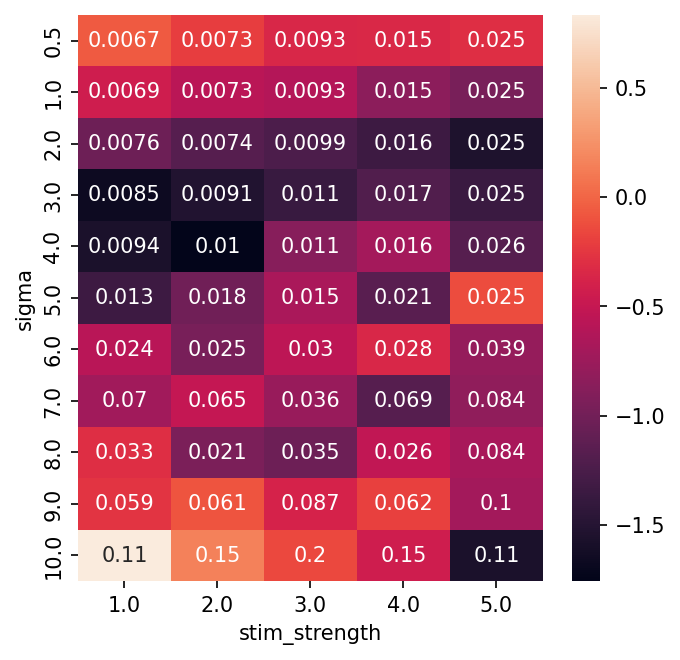

In [78]:
sns.heatmap(sub_df.pivot('sigma', 'stim_strength', 'error_beta'), annot=sub_df.pivot('sigma', 'stim_strength', 'cov_smax'))

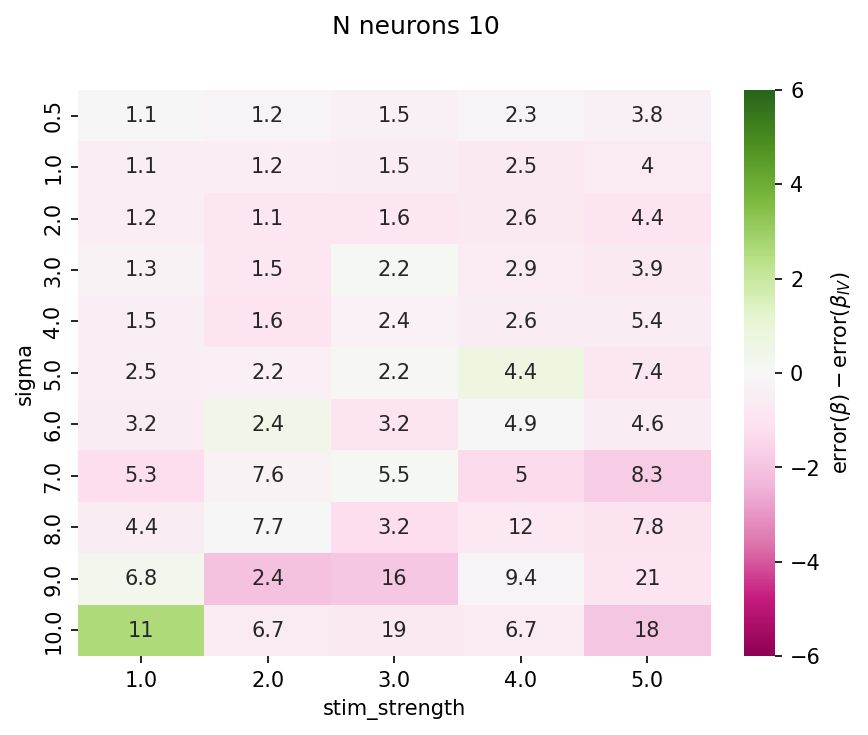

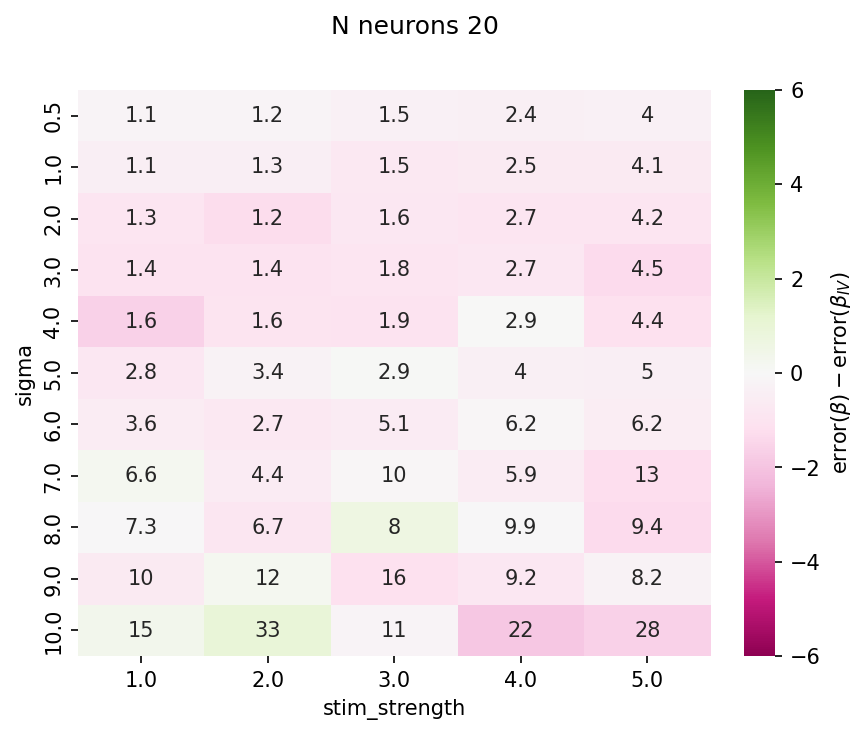

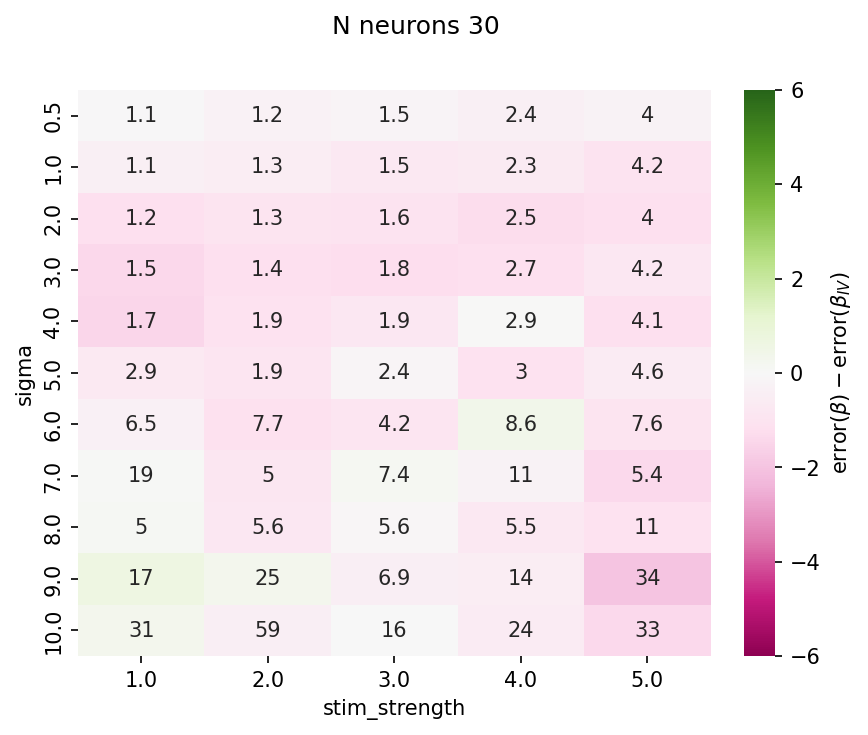

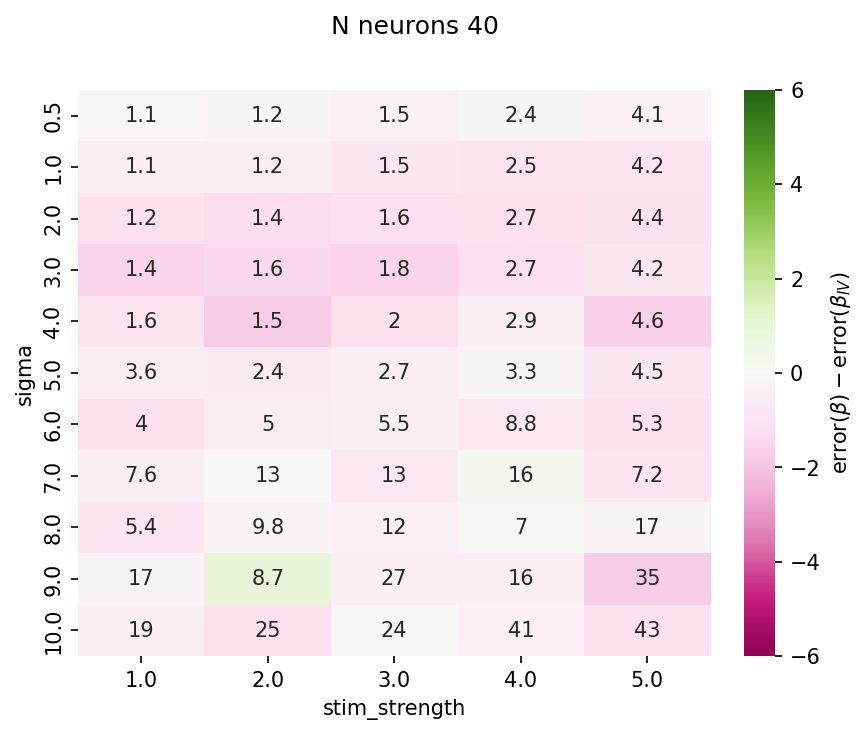

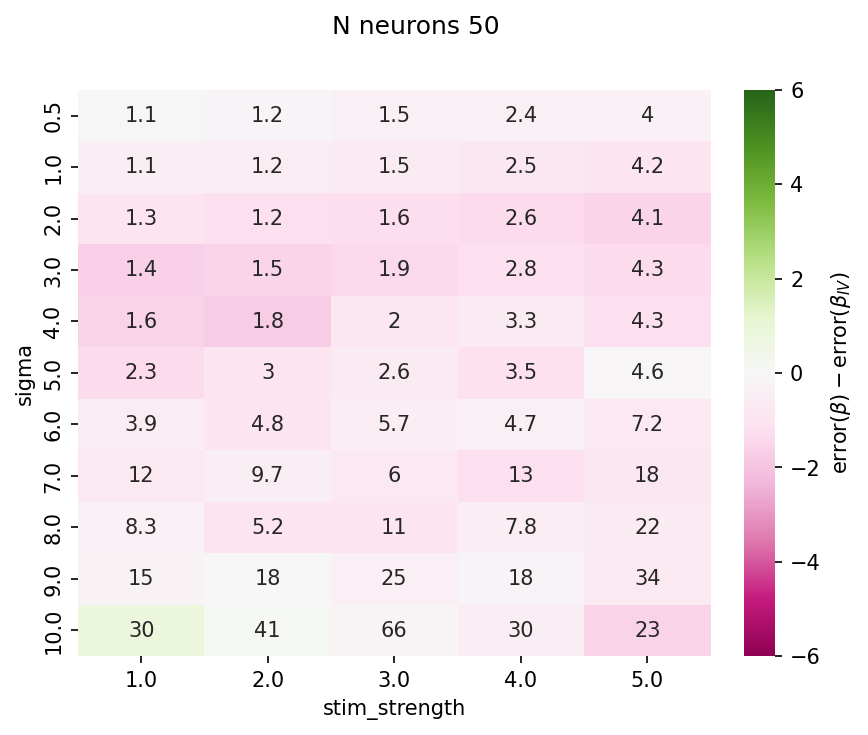

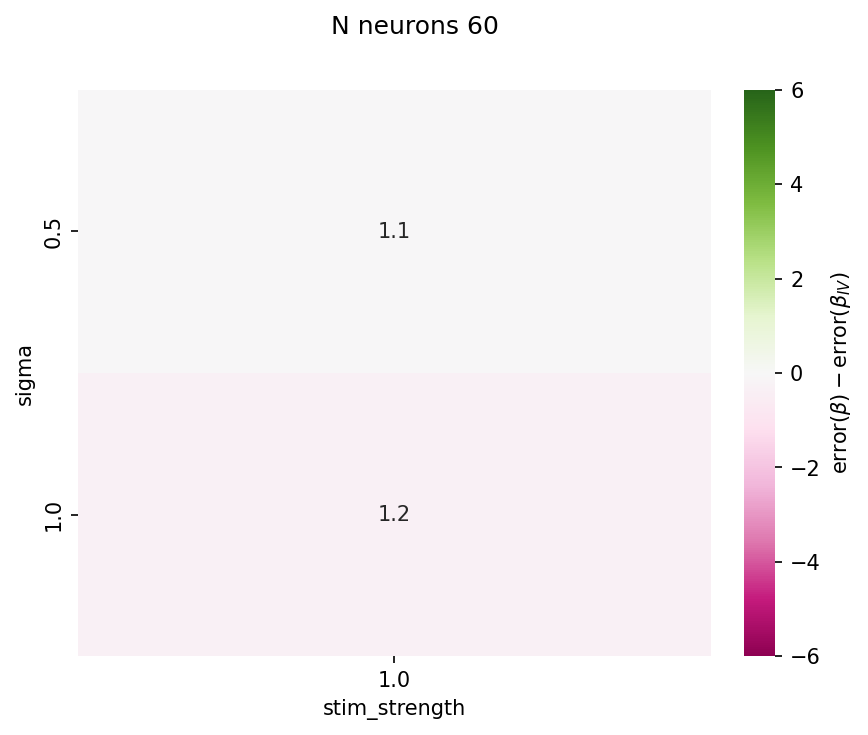

In [80]:
for n_neurons, df in data_df.groupby('n_neurons'):
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(6,5))
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_diff'), 
        annot=df.pivot('sigma', 'stim_strength', 'cov_condition'), 
        cmap='PiYG', vmin=-6, vmax=6, cbar_ax=cax, ax=ax, cbar_kws={'label': r'$\mathrm{error}(\beta) - \mathrm{error}(\beta_{IV})$'})
    fig.suptitle(f'N neurons {n_neurons}')
# ax.set_ylabel('Stimulus strength')
# ax.set_xlabel(r'$\sigma$')